<h1><b>Implementation and improvement</b>
<b>of original VGG-16 using CIFAR dataset</b></h1>

#Imports

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix

In [2]:
def save_model(model, path):
  torch.save(model.state_dict(), path)

def load_model(model, path):
  model.load_state_dict(torch.load(path))

# Dataset

In [5]:
data_dir = '/content'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [6]:
def load_cifar_dataset():

  """
  Function to load the CIFAR10 dataset that returns a separate train and test set.
  Images resized to 64x64 and normalised using the datasets mean and std.
  """


  train_data = datasets.CIFAR10(data_dir, train=True, download=True,
                             transform=transforms.Compose([
                               transforms.Resize(64),                                                                                
                               transforms.ToTensor(),
                               transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768))
                             ]))

  test_data = datasets.CIFAR10(data_dir, train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               transforms.Resize(64),                                      
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768))
                             ]))
  
  return train_data, test_data


def split_train_val(train_data):
  """
  Split data into train and validation sets
  """
  
  train_set, val_set = torch.utils.data.random_split(train_data, [45000, 5000])
  return train_set, val_set

def get_classes(dataset):
  return dataset.classes

In [7]:
train_data, test_data = load_cifar_dataset()

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/cifar-10-python.tar.gz to /content
Files already downloaded and verified


In [8]:
print(train_data)
print(test_data)

classes = get_classes(train_data)
print(classes)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /content
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.49139968, 0.48215827, 0.44653124), std=(0.24703233, 0.24348505, 0.26158768))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: /content
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.49139968, 0.48215827, 0.44653124), std=(0.24703233, 0.24348505, 0.26158768))
           )
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [9]:
train_set, val_set = split_train_val(train_data)

In [10]:
batch_size = 128

train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

# Initial Visualisation

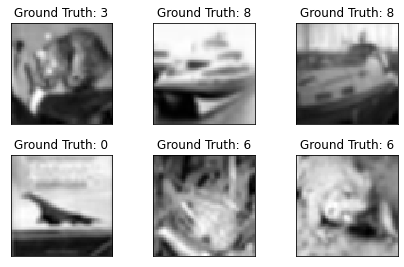

In [12]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='binary_r', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

# Original VGG-16 Model

In [10]:
cfg = {
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
}

class VGG(nn.Module):
    def __init__(self, vgg_name, num_classes, use_bn, init_weights: bool = True, dropout: float=0.5):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name],use_bn)
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, num_classes),
        )
        self._initialize_weights()
        
    

    def _create_classifer(self,num_classes):
        return nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def _initialize_weights(self) -> None:
      for m in self.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _make_layers(self, cfg, use_bn):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
              if use_bn:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                            nn.BatchNorm2d(x), # added batch normalizaiton layers
                            nn.ReLU(inplace=True)]
              else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                               nn.ReLU(inplace=True)]


              in_channels = x

        return nn.Sequential(*layers)

In [11]:
vgg_16 = VGG('VGG16',10, False)

In [12]:
vgg_16 = vgg_16.to(device)

print(vgg_16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Training functions

In [4]:
def train(model, train_loader, loss_function, optimizer, epoch):
    """
    Training function for one epoch to be called in model_fit function
    """

    model.train()
    train_loss = 0
    train_correct = 0

    for idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)
        
        # compute loss
        output = model(data)
        loss = loss_function(output, target)


        # update using gradient
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #correct = predictions(output, target)

        pred = output.data.max(1, keepdim=True)[1]
        correct = pred.eq(target.data.view_as(pred)).cpu().sum()

        train_correct += correct
        train_loss += loss.data.item()

        if (idx + 1)% 50 == 0:

          print('Epoch Progress: {:.0f}% Done\tCurrent Loss: {:.5f}'.format(100. * (idx + 1) / len(train_loader), loss.data.item()))
    
    # Get training epoch loss and accuracy
    train_loss /= len(train_loader.dataset)
    epoch_acc = float(train_correct) / len(train_loader.dataset)
    print('\nAverage training loss: {:.5f}, Training Accuracy: {}/{} ({:.3f}%)'.format(
      train_loss, train_correct, len(train_loader.dataset),100.0 * epoch_acc))
    return train_loss, epoch_acc

def validate(model, val_loader, loss_function):
    """
    Function to evaluate model at certain epoch on the validation set
    """
    model.eval()
    val_loss = 0
    val_correct = 0

    with torch.no_grad():
      for idx, (data, target) in enumerate(val_loader):

          data = data.to(device)
          target = target.to(device)
          
          output = model(data)
          val_loss += loss_function(output, target).data.item()

          #correct = predictions(output, target)
          #val_correct+=correct

          pred = output.data.max(1, keepdim=True)[1]
          val_correct += pred.eq(target.data.view_as(pred)).cpu().sum()
          
      val_loss /= len(val_loader.dataset)
      epoch_acc = float(val_correct) / len(val_loader.dataset)
      print('Average validation loss: {:.5f}, Validation Accuracy: {}/{} ({:.3f}%)\n'.format(
          val_loss, val_correct, len(val_loader.dataset),100.0 * epoch_acc))
    return val_loss, epoch_acc

def test(model, test_loader):
    model.eval()

    images = []
    labels = []
    predict = []

    correct = 0
    with torch.no_grad():
    
        for idx, (data, target) in enumerate(test_loader):

          data = data.to(device)
          target = target.to(device)

          
          output = model(data)
          
          prediction = output.data.max(1, keepdim=True)[1]
          correct += prediction.eq(target.data.view_as(prediction)).cpu().sum()


          images.append(data)
          labels.append(target)
          predict.append(prediction)

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    predict = torch.cat(predict, dim = 0)

    acc = float(correct) / len(test_loader.dataset)
    print('\nTest set Accuracy: {}/{} ({:.3f}%)\n'.format(correct, len(test_loader.dataset), 100.0 * acc))
    return images, labels, predict

def model_fit(model, num_epochs, train_loader, val_loader, optimizer, loss_function):
  best_acc = 0.0
  history = { "train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "epoch_time": [] }
  start_time = time.time()
  for epoch in range(num_epochs):

    epoch_start_time = time.time()
    print("\nTrain Epoch {}: ".format(epoch+1))

    epoch_train_loss, epoch_train_acc = train(model, train_loader, loss_function, optimizer, epoch)
    epoch_val_loss, epoch_val_acc = validate(model, val_loader, loss_function)

    # Store acuracy and loss scores for current epoch
    history['train_acc'].append(epoch_train_acc)
    history['train_loss'].append(epoch_train_loss)
    history['val_acc'].append(epoch_val_acc)
    history['val_loss'].append(epoch_val_loss)

    epoch_end_time = time.time()
    epoch_time = epoch_end_time - epoch_start_time
    print("Epoch %d of %d. Time taken: %.2fs" % (epoch+1, num_epochs, epoch_time))
    history["epoch_time"].append(epoch_time)
    
  training_time = time.time() - start_time
  print('\nTotal time taken: {:.2f}s'.format(training_time))

  return model, history

# Plotting functions

In [39]:
def plot_incorrect(images, labels, pred_labels):
  incorrect_image = []
  incorrect_labels = []
  correct_labels = []


  for i in range(len(images)-1):

    if labels[i] != pred_labels[i]:
      incorrect_image.append(images[i])
      correct_labels.append(labels[i])
      incorrect_labels.append(pred_labels[i])



  fig = plt.figure(figsize = (16, 16))
  rows = 4
  cols = 4

  for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_labels, false_label = incorrect_image[i], correct_labels[i], incorrect_labels[i]
        image = image.squeeze()
        image = image.permute(1,2,0)
        true_class = true_labels.cpu().numpy().astype(str)
        incorrect_class = false_label.cpu().numpy()[0].astype(str)

        ax.imshow(image.cpu().numpy(),cmap="gray")
        ax.set_title(f'true label: {true_class} \n' \
                         f'pred label: {incorrect_class} ')
        ax.axis('off')


  fig.subplots_adjust(hspace = 0.3)

In [14]:
def plot_results(e, h, info, name):
    epochs_range = [i for i in range(e)]

    fig, (loss_plot, acc_plot) = plt.subplots(1, 2, figsize =(12,4))

    loss_plot.plot(epochs_range, h['train_loss'], color='red', label='train loss')
    loss_plot.plot(epochs_range, h['val_loss'], color='green', label='val loss')
    loss_plot.set_title('Epochs - Loss | {}'.format(info))
    loss_plot.legend()

    acc_plot.plot(epochs_range, h['train_acc'], color='red', label='train acc')
    acc_plot.plot(epochs_range, h['val_acc'], color='green', label='val acc')
    acc_plot.set_title('Epochs - Accuracy | {}'.format(info))
    acc_plot.legend()
    plt.savefig(name)
    plt.show()




In [15]:
def plot_confusion_matrix(labels, pred_labels, classes):

    cf_matrix = confusion_matrix(labels.cpu(), pred_labels.cpu())
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)
    return cf_matrix

# Model Training

In [17]:
epochs = 50
lr = 0.001    

optimizer = torch.optim.SGD(vgg_16.parameters(), lr=lr, momentum=0.9)
loss_function = nn.CrossEntropyLoss()

vgg_original, history = model_fit(
    model = vgg_16, 
    num_epochs = epochs, 
    train_loader = train_loader, 
    val_loader = val_loader,
    optimizer = optimizer,
    loss_function = loss_function,
  )


Train Epoch 1: 
Epoch Progress: 14% Done	Current Loss: 2.29984
Epoch Progress: 28% Done	Current Loss: 2.28700
Epoch Progress: 43% Done	Current Loss: 2.27619
Epoch Progress: 57% Done	Current Loss: 2.22416
Epoch Progress: 71% Done	Current Loss: 2.17749
Epoch Progress: 85% Done	Current Loss: 2.00733
Epoch Progress: 99% Done	Current Loss: 1.84009

Average training loss: 0.01712, Training Accuracy: 7628/45000 (16.951%)
Average validation loss: 0.01529, Validation Accuracy: 1443/5000 (28.860%)

Epoch 1 of 50. Time taken: 84.37s

Train Epoch 2: 
Epoch Progress: 14% Done	Current Loss: 1.85045
Epoch Progress: 28% Done	Current Loss: 1.75582
Epoch Progress: 43% Done	Current Loss: 1.75745
Epoch Progress: 57% Done	Current Loss: 1.71529
Epoch Progress: 71% Done	Current Loss: 1.79546
Epoch Progress: 85% Done	Current Loss: 1.57195
Epoch Progress: 99% Done	Current Loss: 1.57550

Average training loss: 0.01371, Training Accuracy: 15707/45000 (34.904%)
Average validation loss: 0.01293, Validation Accura

In [18]:
original_model = '/content/vgg16_mnist.pth'

save_model(vgg_original, original_model)

In [19]:
images, labels, pred_labels = test(vgg_original, test_loader)


Test set Accuracy: 7628/10000 (76.280%)



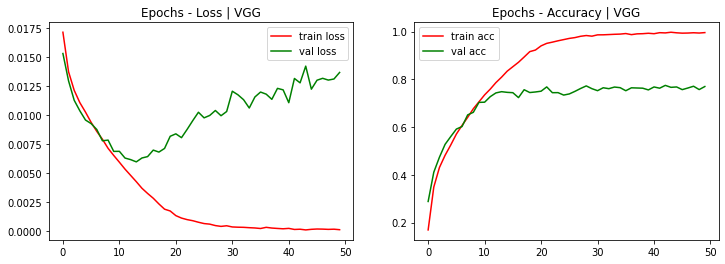

In [20]:
plot_results(epochs, history, info='VGG', name='original_VGG_16_plot')

array([[865,   7,  30,  16,   7,   3,   7,   8,  45,  12],
       [ 31, 825,   4,   8,   5,   1,  11,   5,  36,  74],
       [ 75,   2, 689,  47,  55,  33,  41,  43,  12,   3],
       [ 24,   3,  83, 628,  48,  74,  62,  50,  17,  11],
       [ 14,   2,  71,  63, 717,  13,  43,  66,  11,   0],
       [ 11,   3,  52, 229,  39, 562,  20,  66,  12,   6],
       [ 11,   1,  42,  44,  25,   7, 843,  12,  12,   3],
       [ 18,   0,  24,  44,  35,  26,   2, 838,   4,   9],
       [ 65,  16,   6,  12,   7,   3,   3,   4, 874,  10],
       [ 49,  60,   6,  21,   4,   3,   8,  27,  35, 787]])

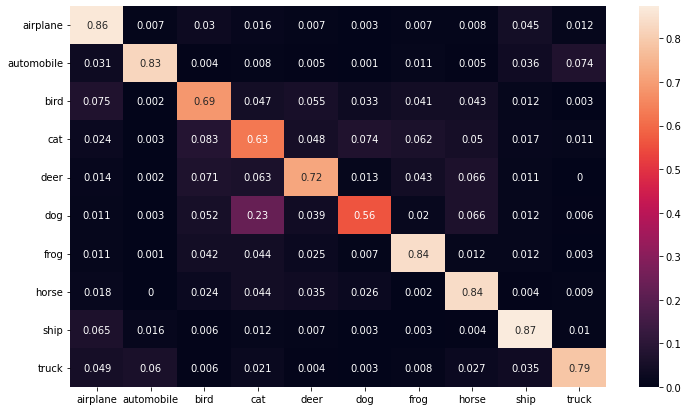

In [21]:
plot_confusion_matrix(labels, pred_labels, classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

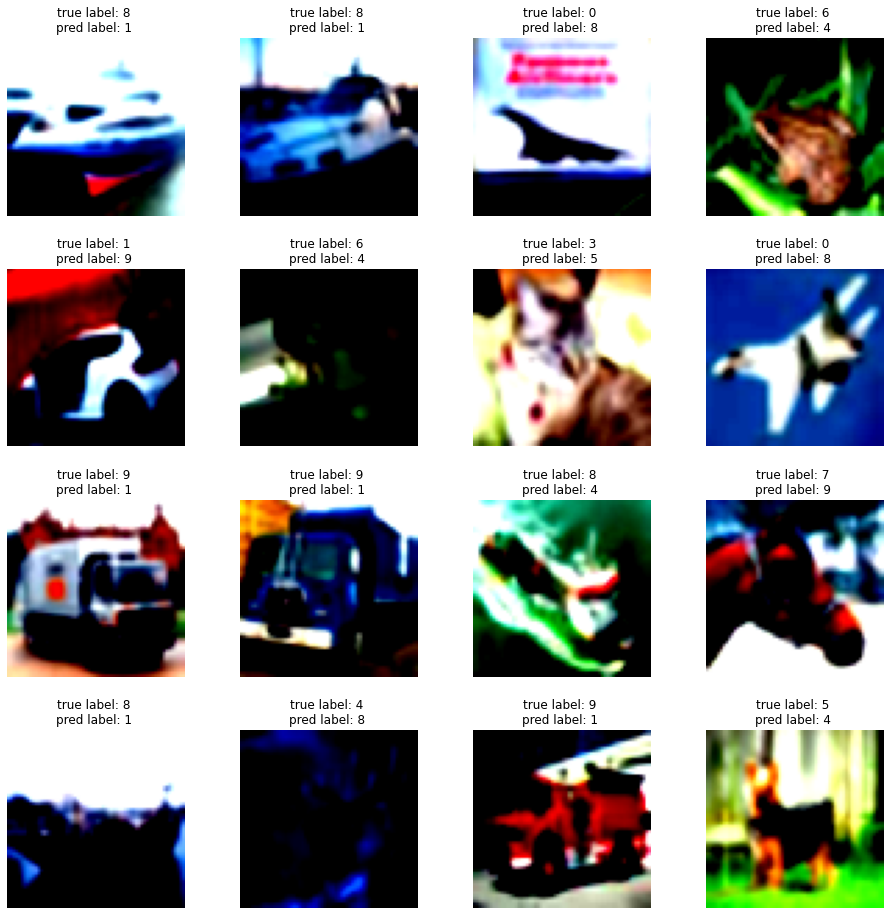

In [40]:
plot_incorrect(images, labels, pred_labels)

# **Improvement on VGG-16**

# Data Augmentation

In [21]:
data_dir = '/content/'

def load_augmented_cifar_dataset():

  """
  Function to load the cifar dataset that returns a separate train and test set.
  Images resized to 64x64 and normalised using the datasets mean and std. This time data augmnentation
  is applied.
  """


  train_data = datasets.CIFAR10(data_dir, train=True, download=True,
                             transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.RandomAffine(degrees=20, translate=(0.2,0.2), scale=(0.7,1.3)),                                                                             
                               transforms.ToTensor(),
                               transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768))
                             ]))

  test_data = datasets.CIFAR10(data_dir, train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               transforms.Resize(64),                                      
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768))
                             ]))
  
  return train_data, test_data

In [22]:
train_data, test_data = load_augmented_cifar_dataset()

classes = get_classes(train_data)

train_set, val_set = split_train_val(train_data)

batch_size = 128

train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


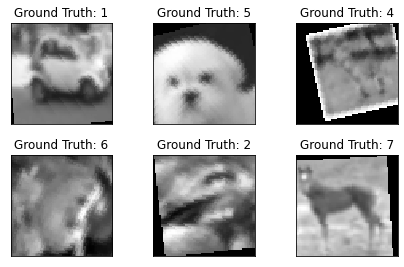

In [23]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

# Improved model

In [24]:
cfg = {
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
}

class VGG_improved(nn.Module):
    def __init__(self, vgg_name, num_classes, use_bn, init_weights: bool = True, dropout: float=0.5):
        super(VGG_improved, self).__init__()
        self.features = self._make_layers(cfg[vgg_name],use_bn)
        self.avgpool = nn.AdaptiveMaxPool2d((5, 5))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 5 * 5, 4096),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, num_classes),
        )
        self._initialize_weights()
        
  

    def _initialize_weights(self) -> None:
      for m in self.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _make_layers(self, cfg, use_bn):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
              if use_bn:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                            nn.BatchNorm2d(x), # added batch normalizaiton layers
                            nn.ReLU(inplace=True)]
              else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                               nn.ReLU(inplace=True)]


              
              
              in_channels = x

        return nn.Sequential(*layers)

In [25]:
vgg_16_improved = VGG_improved('VGG16',10, True)
vgg_16_improved = vgg_16_improved.to(device)
print(vgg_16_improved)

VGG_improved(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d

In [41]:
epochs = 50
lr = 0.001

optimizer = torch.optim.SGD(vgg_16_improved.parameters(), lr=lr, momentum=0.9, weight_decay=1e-5)
loss_function = nn.CrossEntropyLoss()
#loss_function = LabelSmoothingLoss(smoothing = 0.1, reduction="mean")

vgg_improved, history_improved = model_fit(
    model = vgg_16_improved, 
    num_epochs = epochs, 
    train_loader = train_loader, 
    val_loader = val_loader,
    optimizer = optimizer,
    loss_function = loss_function,
  )


Train Epoch 1: 
Epoch Progress: 14% Done	Current Loss: 1.51211
Epoch Progress: 28% Done	Current Loss: 1.41465
Epoch Progress: 43% Done	Current Loss: 1.37934
Epoch Progress: 57% Done	Current Loss: 1.38559
Epoch Progress: 71% Done	Current Loss: 1.27315
Epoch Progress: 85% Done	Current Loss: 1.55825
Epoch Progress: 99% Done	Current Loss: 1.27044

Average training loss: 0.01147, Training Accuracy: 20528/45000 (45.618%)
Average validation loss: 0.01091, Validation Accuracy: 2523/5000 (50.460%)

Epoch 1 of 50. Time taken: 97.54s

Train Epoch 2: 
Epoch Progress: 14% Done	Current Loss: 1.41366
Epoch Progress: 28% Done	Current Loss: 1.31167
Epoch Progress: 43% Done	Current Loss: 1.36852
Epoch Progress: 57% Done	Current Loss: 1.40233
Epoch Progress: 71% Done	Current Loss: 1.37896
Epoch Progress: 85% Done	Current Loss: 1.51299
Epoch Progress: 99% Done	Current Loss: 1.22823

Average training loss: 0.01057, Training Accuracy: 22720/45000 (50.489%)
Average validation loss: 0.00990, Validation Accur

In [42]:
images, labels, pred_labels = test(vgg_improved, test_loader)


Test set Accuracy: 8246/10000 (82.460%)



In [ ]:
improved_model = '/content/vgg16_improved_mnist.pth'

save_model(vgg_improved, improved_model)

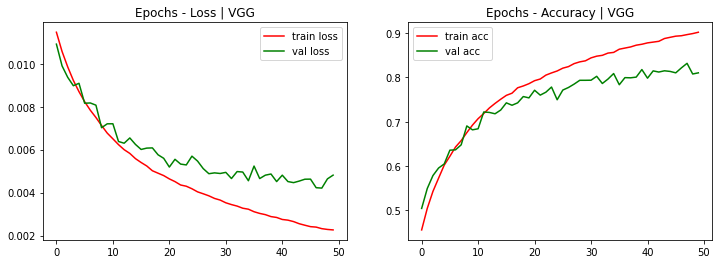

In [43]:
plot_results(epochs, history_improved, info='VGG', name='improved_VGG_16_plot')

array([[906,  22,  19,   2,   8,   0,   2,   9,  29,   3],
       [  9, 976,   0,   1,   0,   0,   0,   2,   6,   6],
       [ 48,  12, 729,  15,  55,   9,  57,  53,  15,   7],
       [ 26,  22,  40, 583,  48,  93,  48,  84,  47,   9],
       [ 13,   6,  22,  16, 801,  10,  33,  89,   9,   1],
       [ 10,  11,  20,  69,  41, 715,  18,  97,   9,  10],
       [ 10,   6,  13,  29,  15,   8, 899,  12,   7,   1],
       [ 18,   4,   5,   5,   9,   3,   2, 944,   3,   7],
       [ 51,  22,   1,   0,   1,   1,   3,   1, 915,   5],
       [ 42, 149,   1,   0,   2,   2,   4,   3,  19, 778]])

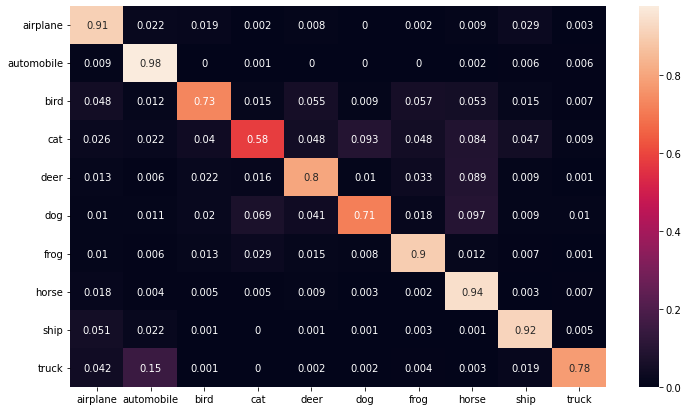

In [44]:
plot_confusion_matrix(labels, pred_labels, classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

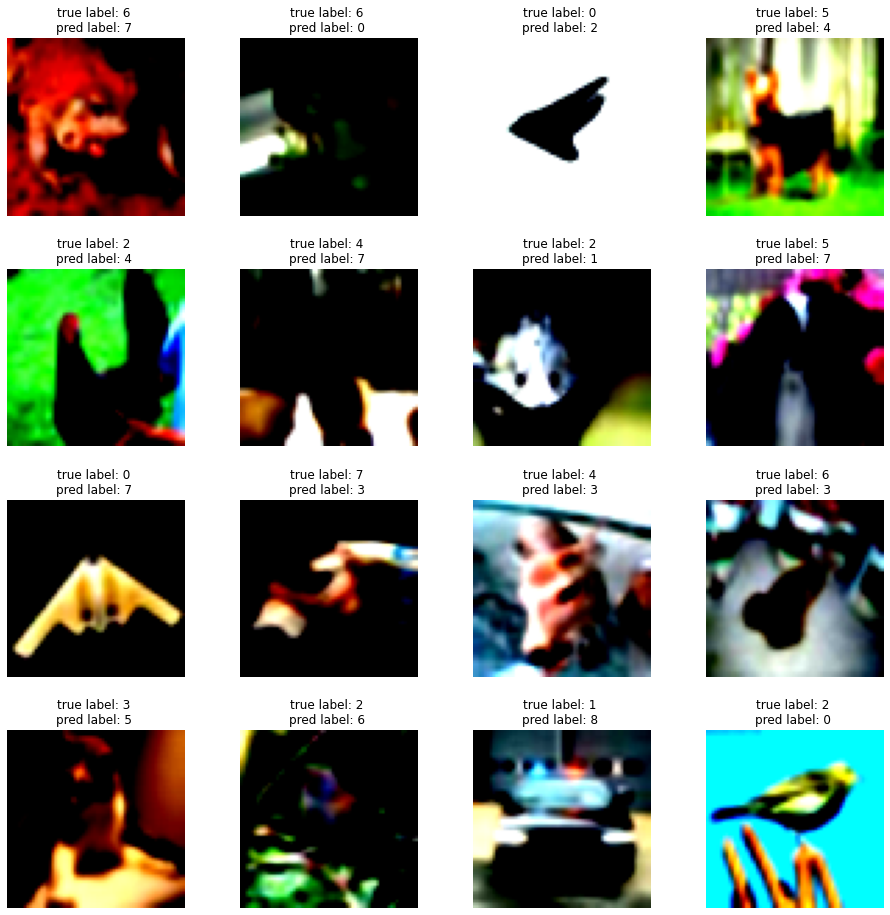

In [45]:
plot_incorrect(images, labels, pred_labels)